In [53]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import numpy as np
import librosa
import scipy
from IPython.display import Audio
from librosa.feature.inverse import mel_to_audio
import ignite
from ignite.metrics import FID, InceptionScore
from ignite.engine import Engine
from torchvision import transforms, models
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import re
from scipy.io import wavfile

from src.train import train
from src.NSynthDataset import NSynthDataset
from src.utils import estimate_pitch, display_audio_sample, display_mel_sample, hz_to_midi, midi_to_hz, clean, filter_mel
from src.SpecGAN import SpecGANGenerator

In [2]:
batch_size = 50
z_size = 1000

# min len =16000
sr = 8191
duration = 2
hop_length, n_fft = 128, 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
os.chdir('../../..')
path = 'mnt/data/public/NSynth/'

In [4]:
train_set = NSynthDataset(data_path=path,
                          mel=True,  pitched_z=False, 
                          sampling_rate=sr, duration=duration, 
                          min_class_count=10000, max_class_count=3000,
                          z_size=z_size)

In [5]:
test_set = NSynthDataset(data_path=path,
                          stage='test',
                          mel=True,  pitched_z=False, 
                          sampling_rate=sr, duration=duration, 
                          cond_classes=train_set.cond_classes,
                          return_pitch=True,
                          z_size=z_size)

In [37]:
gen = SpecGANGenerator(z_size, train_set.label_size, train_set.y_size).to(device)

gen.load_state_dict(torch.load(f'users/adcy353/GANs-Conditional-Audio-Synthesis/models/spec2/G_0.0001-1-827.pt'))
gen.eval()

SpecGANGenerator(
  (fc): Linear(in_features=1006, out_features=16384, bias=True)
  (deconv): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (9): Tanh()
  )
)

In [38]:
def display_spec(specs, f0=None):
    fig, axs = plt.subplots(1, len(specs), figsize=(10, 3))
    for i in range(len(specs)):
        #librosa.display.specshow(librosa.power_to_db(specs[i], ref=np.max),  y_axis='mel', x_axis='time', ax=axs[i], cmap='magma')
        librosa.display.specshow(np.array(specs[i]),  y_axis='mel', x_axis='time', ax=axs[i], cmap='magma')
        axs[i].set_title('Mel Spectrogram')
    plt.show()    



bass_synthetic 49 C♯


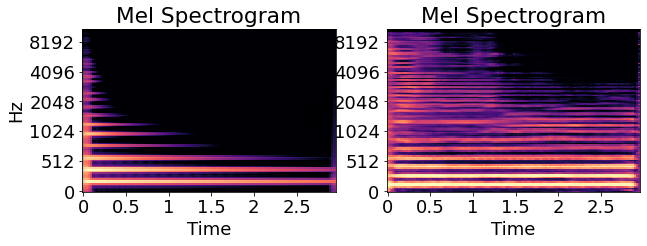

65.15499408113624 F

organ_electronic 63 D♯


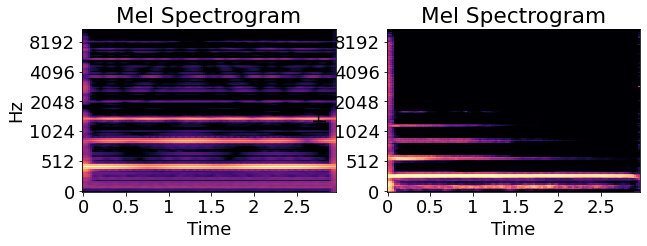

60.1712142612503 C

string_acoustic 46 A♯


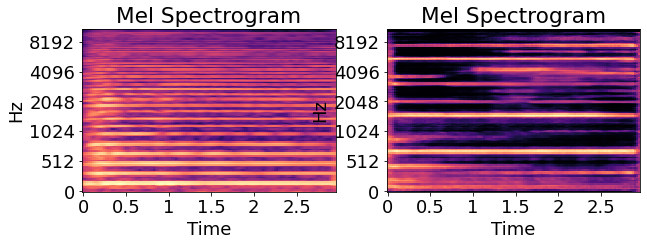

71.47321145304 B

bass_synthetic 79 G


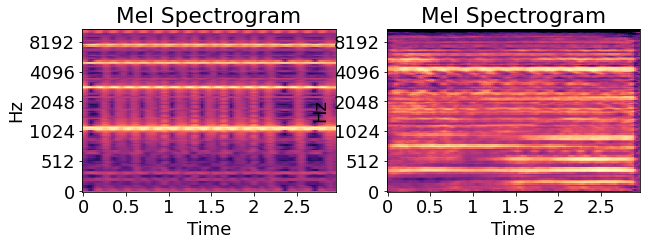

65.44776632709754 F

organ_electronic 67 G


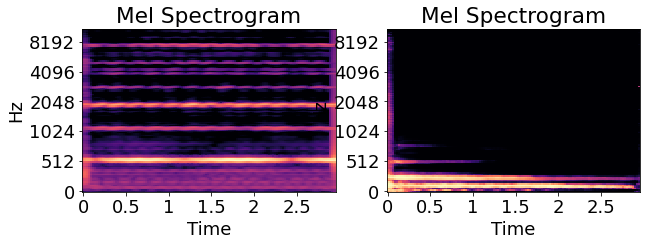

62.77347761224899 D♯

bass_synthetic 76 E


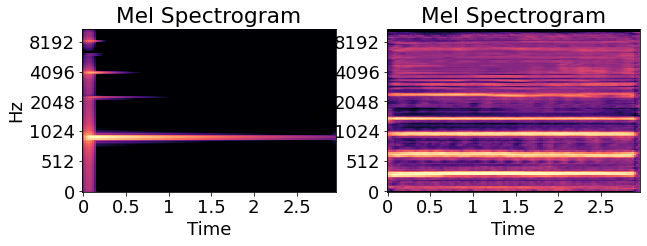

68.73827754391398 A

bass_synthetic 78 F♯


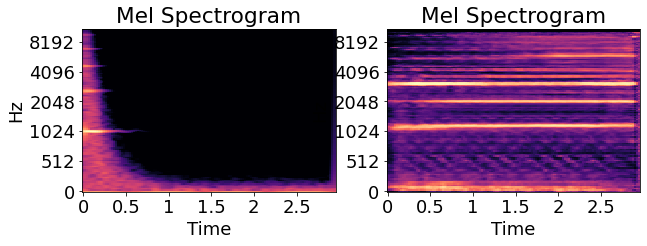

68.31724882336597 G♯

keyboard_electronic 69 A


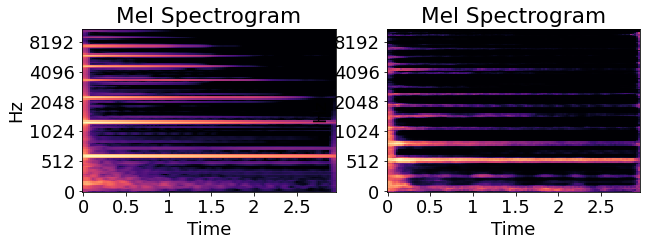

67.15725296916683 G

organ_electronic 69 A


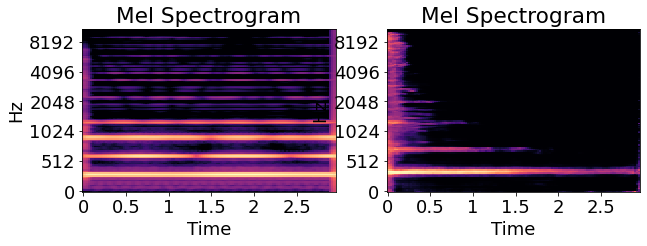

60.1712142612503 C


In [39]:
s_i = []
for i in range(0, 900, 100):
    w, l, z, pitch = test_set.__getitem__(i)
    inst = test_set.annot.loc[test_set.fnames[i], 'instrument_class_str']
    
    print(f'\n{inst} {pitch.item()} {librosa.midi_to_note(pitch, octave=False).item()}')
    s = gen.forward(z.unsqueeze(0).to(device), l.unsqueeze(0).to(device))
    s.to(torch.device('cpu'))
    s = s.detach().cpu()
    
    #s_f = s.clone()
    #s_f = scipy.signal.medfilt2d(s, kernel_size=(3, 3))  # Adjust kernel_size as needed
    s[126:] = s.min()
    #s_f[70:] = 0#s_f.min()
    #s_f = filter_mel(s_f, sr)
    display_spec((w, s))#, s_f))
    
    w_audio = mel_to_audio(np.array(w), sr=train_set.sampling_rate, n_fft=n_fft, hop_length=hop_length)
    s_audio = mel_to_audio(np.array(s), sr=train_set.sampling_rate, n_fft=n_fft, hop_length=hop_length)
    #s_f_audio = mel_to_audio(np.array(s_f), sr=train_set.sampling_rate, n_fft=n_fft, hop_length=hop_length)
    #s_f_audio = clean(s_audio, sr)
    
    
    #display_mel_sample(i, train_set, gen)
    #librosa.display.specshow(np.array(specs[i]),  y_axis='mel', x_axis='time', ax=axs[i], cmap='magma')

    display(Audio(w_audio, rate=train_set.sampling_rate))
    display(Audio(s_audio, rate=train_set.sampling_rate))
    #display(Audio(s_f_audio, rate=train_set.sampling_rate))
    
    pitch, f0 = estimate_pitch(s_audio, sr)#f_audio, sr)
    print(pitch, librosa.midi_to_note(pitch, octave=False)) 

transform = transforms.Compose([
    transforms.ToTensor(),            # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])
    
# Define the process function for evaluation
def evaluation_step(engine, batch):
    gen.eval()
    _, l, z = batch
    z = transform(z)
    l = l.to(next(gen.parameters()).device)  # Ensure condition tensor is on the same device
    z = z.to(next(gen.parameters()).device)  # Ensure noise tensor is on the same device
    
    with torch.no_grad():
        predictions = gen(z, l)
    return predictions.view(predictions.shape[0], -1)


# Ensure the generator model is on the same device as the generator's parameters
gen = gen.to(next(gen.parameters()).device)

# Create an instance of the InceptionScore metric
inception_score_metric = InceptionScore(num_features=16384)#, feature_extractor=gen)  # Adjust num_features as needed

# Create an evaluator engine
evaluator = Engine(evaluation_step)

# Attach the Inception Score metric to the evaluator
inception_score_metric.attach(evaluator, "inception_score")

# Replace with loading your test dataset
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Run the evaluation
for batch in test_dataloader:
    state = evaluator.run([batch])

# Access and print the Inception Score
inception_score = inception_score_metric.compute()
print("Inception Score:", inception_score)


metric = InceptionScore()
metric.attach(default_evaluator, "is")
state = default_evaluator.run([y])
print(state.metrics["is"])

## Outputs sample

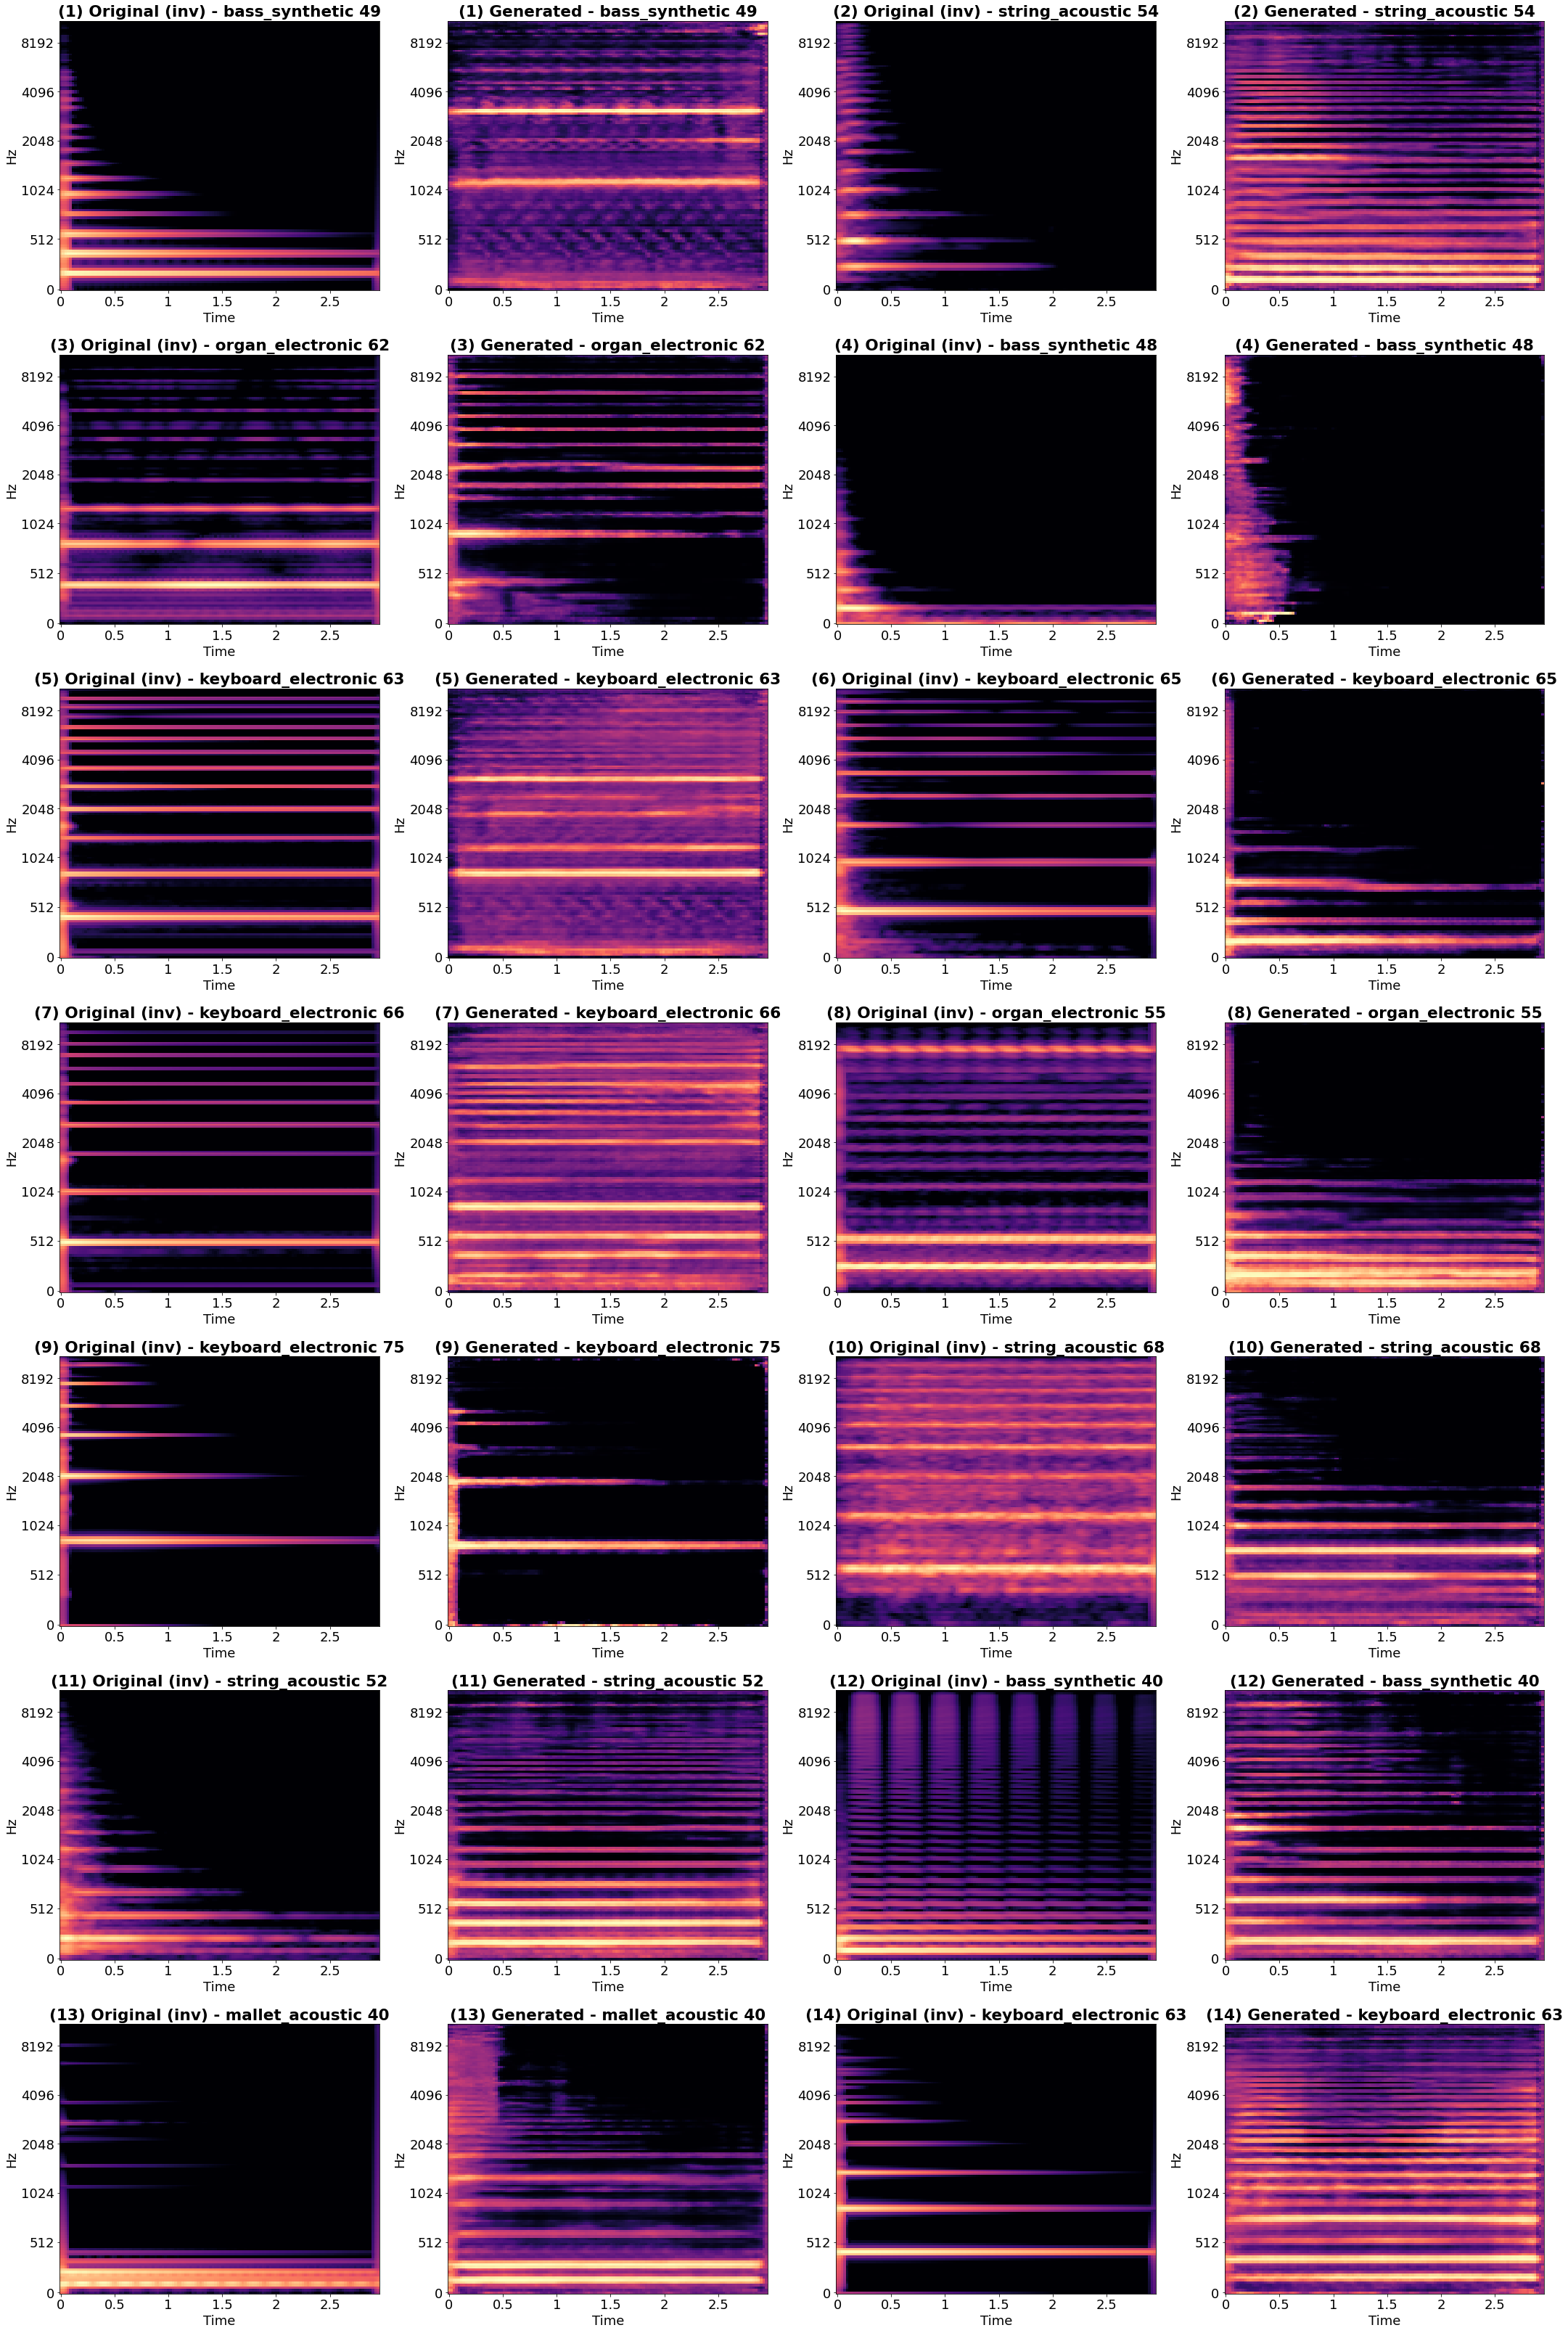

In [56]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(7, 4, figsize=(30, 45))
for a, i in enumerate(range(0, 1200, 86)):
    w, l, z, pitch = test_set.__getitem__(i)
    inst = test_set.annot.loc[test_set.fnames[i], 'instrument_class_str']
    
    label = f'{inst} {pitch.item()}'
    orig_label = f'({a+1}) Original (inv) - {label}'
    gen_label = f'({a+1}) Generated - {label}'
    
    s = gen.forward(z.unsqueeze(0).to(device), l.unsqueeze(0).to(device))
    s.to(torch.device('cpu'))
    s = s.detach().cpu()
    
    librosa.display.specshow(np.array(w), y_axis='mel', x_axis='time', ax=ax.flatten()[2*a], cmap='magma')
    librosa.display.specshow(np.array(s), y_axis='mel', x_axis='time', ax=ax.flatten()[2*a+1], cmap='magma')
    ax.flatten()[2*a].set_title(orig_label, fontdict={'fontsize':'large', 'weight':'bold'})
    ax.flatten()[2*a+1].set_title(gen_label, fontdict={'fontsize':'large', 'weight':'bold'})
    fig.tight_layout() 
    
    w_audio = mel_to_audio(np.array(w), sr=sr, n_fft=1024, hop_length=128)
    s_audio = mel_to_audio(np.array(s), sr=sr, n_fft=1024, hop_length=128)
    
    folder = 'users/adcy353/GANs-Conditional-Audio-Synthesis/results/spec/'
    wavfile.write(f'{folder}{orig_label}.wav', sr, np.array(w_audio).astype(np.float32))
    wavfile.write(f'{folder}{gen_label}.wav', sr, np.array(s_audio).astype(np.float32))


In [40]:
test_set.__len__()

1202

In [41]:
b_size = 50
testloader = DataLoader(test_set, b_size, shuffle=False, drop_last=True)

In [42]:
pitches_diff = []
est_pitch = []
real_pitch = []
for data in tqdm(testloader, leave=True):
    # forward pass
    x, l, z, p = data
    gen.eval()
    s = gen(z.to(device), l.to(device))
    #s[126:] = s.min()
    
    # audio reconstruction
    s_audio = []
    for i in range(b_size):
        audio = mel_to_audio(np.array(s[i].detach().cpu()), sr=sr, n_fft=n_fft, hop_length=hop_length)
        s_audio.append(audio)

        
    # pitch diff and accuracy
    p_est = torch.tensor([estimate_pitch(row, sr)[0] for row in s_audio]).unsqueeze(1)
    est_pitch.append(p_est)
    pitch_diff = abs(p_est - p)
    pitches_diff.append(pitch_diff)
    real_pitch.append(p)

100%|██████████| 24/24 [11:47<00:00, 29.47s/it]


## Pitch diff

In [43]:
diffs = torch.cat(pitches_diff, dim=0)
diffs.mean().item(), diffs.median().item()

(13.791830781831326, 11.020478186570429)

<BarContainer object of 61 artists>

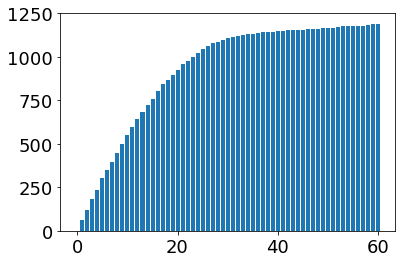

In [44]:
x = range(int(diffs.max()) + 1)
y = [(diffs < thresh).sum().round() for thresh in x]
plt.bar(x, y)

No handles with labels found to put in legend.


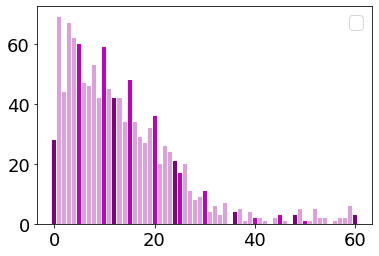

In [45]:
colors = list(range(len(x)))
for i in range(len(x)):
    if x[i] % 12 == 0:
        colors[i] = 'purple'
    elif x[i] % 5 == 0:
        colors[i] = 'm'
    else:
        colors[i] = 'plum'

y2 = [(diffs.round() == t).sum() for t in x]
plt.bar(x, y2, color=colors)
plt.legend()

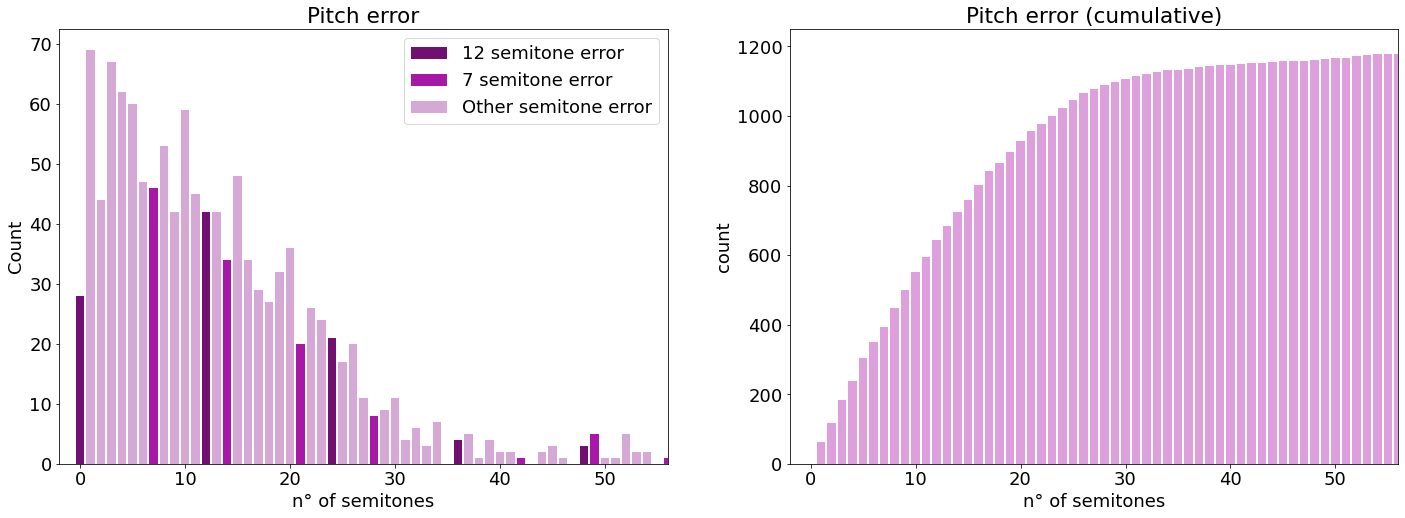

In [46]:
y2 = [(diffs.round() == t).sum().item() for t in x]
colors = [0 for _ in x]
for t in range(len(colors)):
    if t % 12 == 0:
        colors[t] = '12 semitone error'
    elif t % 7 == 0:
        colors[t] = '7 semitone error'
    else:
        colors[t] = 'Other semitone error'

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[1].bar(x, y, color='plum')
ax[1].set_title('Pitch error (cumulative)')
ax[1].set_xlabel('n° of semitones')
ax[1].set_ylabel('count')
ax[1].set_xlim(-2, 56)

df = pd.DataFrame((zip(x, y2, colors)), columns=['x', 'y', 'hue'])
sns.barplot(df, x='x', y='y', hue='hue', ax=ax[0], palette=['purple', 'm', 'plum'], dodge=False, hue_order=['12 semitone error', '7 semitone error', 'Other semitone error'])
ax[0].set_title('Pitch error')
ax[0].set_xlabel('n° of semitones')
ax[0].set_ylabel('Count')
ax[0].set_xticks(list(range(0, 56, 10)))
ax[0].set_xlim(-2, 56)
ax[0].legend(loc='upper right')


## Pitch accuracy

In [47]:
estimated_pitch = torch.cat(est_pitch).round()
real_pitch = torch.cat(real_pitch)

In [48]:
(estimated_pitch == real_pitch).sum() / estimated_pitch.shape[0]

tensor(0.0233)

## Note accuracy

Accuracy = 0.08416666666666667


<AxesSubplot:>

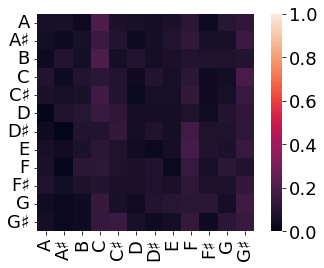

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

estimated_notes = np.array([librosa.midi_to_note(pitch, octave=False).item() for pitch in estimated_pitch])
real_notes = np.array([librosa.midi_to_note(pitch, octave=False).item() for pitch in real_pitch])
acc = accuracy_score(real_notes, estimated_notes)
labels = sorted(np.unique(real_notes))
cm = confusion_matrix(real_notes, estimated_notes, labels=labels, normalize='true')
print(f'Accuracy = {acc}')
sns.heatmap(cm, square=True, xticklabels=labels, yticklabels=labels, vmax=1)

In [21]:
G_loss_h = []
D_loss_h = []

In [22]:
paths = [#'/users/adcy353/GANs-Conditional-Audio-Synthesis/models/wavegan/loss_history-0.txt', 
         '/users/adcy353/GANs-Conditional-Audio-Synthesis/models/spec2/loss_history-0.txt',
         '/users/adcy353/GANs-Conditional-Audio-Synthesis/models/spec2/loss_history-326.txt',
             '/users/adcy353/GANs-Conditional-Audio-Synthesis/models/spec2/loss_history-402.txt']


for path in paths:
    with open(path, 'r') as f:
        lines = f.readlines()

    # Define a regular expression pattern to match the lines
    pattern = r'Epoch \d+: Generator loss = ([\d.]+), Discriminator loss = ([\d.-]+)'

    # Iterate through the lines and extract losses
    for line in lines:
        match = re.search(pattern, line)
        if match:
            G_loss_h.append(float(match.group(1)))
            D_loss_h.append(float(match.group(2)))

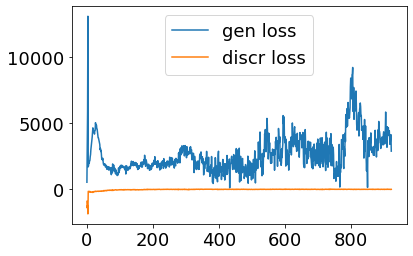

In [23]:
plt.plot(range(len(G_loss_h)), G_loss_h, label='gen loss')
plt.plot(range(len(D_loss_h)), D_loss_h, label='discr loss')
plt.legend()

In [ ]:
Audio(w, rate=sr)

In [ ]:
z_rd = 2 * torch.rand(z_size) - 1
z_noise = z.clone() + z_rd

Text(0.5, 1.0, 'Resulting generator input')

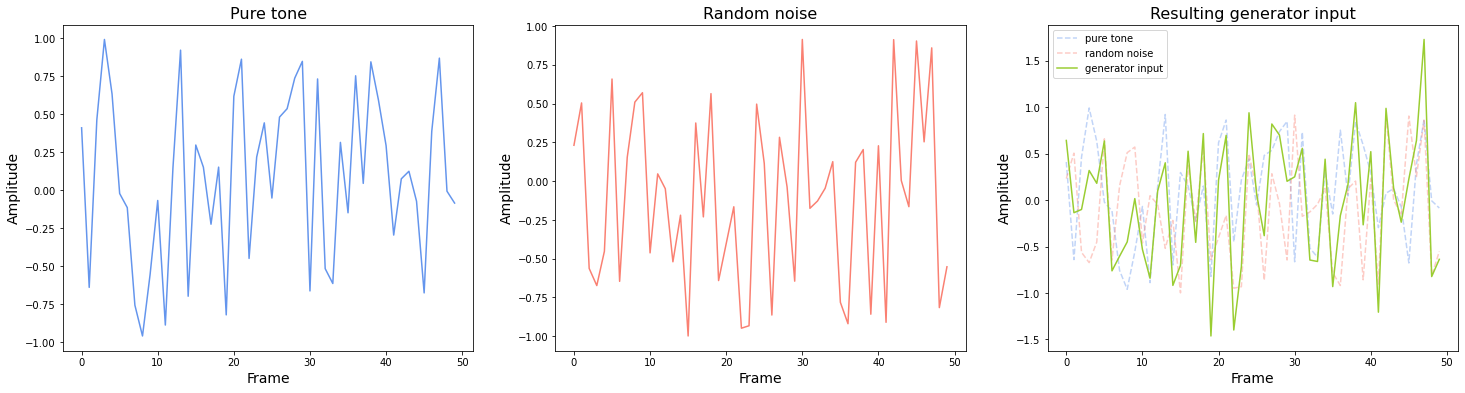

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
ax[0].plot(z[:50], c='cornflowerblue')
ax[1].plot(z_rd[:50], c='salmon')
#ax[2].plot(z_noise[:50], c='yellowgreen')

ax[2].plot(z[:50], 'g--', c='cornflowerblue', alpha=0.4, label='pure tone')
ax[2].plot(z_rd[:50], 'g--', c='salmon', alpha=0.4, label='random noise')
ax[2].plot(z_noise[:50], c='yellowgreen', label='generator input')
ax[2].legend()
           
for a in ax:
    a.set_xlabel('Frame', fontdict={'fontsize': 14})
    a.set_ylabel('Amplitude', fontdict={'fontsize': 14})

ax[0].set_title('Pure tone', fontdict={'fontsize': 16})
ax[1].set_title('Random noise', fontdict={'fontsize': 16})
ax[2].set_title('Resulting generator input', fontdict={'fontsize': 16})
#ax[3].set_title('Generator input')

#fig.title('pitched_input.png')
#fig.savefig('/Users/elisa/Desktop/Thesis/img/pitched_input.png')